1. Have you come across Grid Search Cross Validation? Fit any two models covered in previous 
classes and optimize them using Grid search CV.


In [58]:
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.datasets import load_breast_cancer 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
 

dataset = load_breast_cancer()
X=dataset.data
Y=dataset.target
X_train, X_test, y_train, y_test = train_test_split( 
                        X,Y,test_size = 0.30, random_state = 101) 

model = SVC() 
model.fit(X_train, y_train) 
   
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        66
           1       0.91      0.97      0.94       105

    accuracy                           0.92       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.93      0.92      0.92       171



In [59]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear']}  
   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
#
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        66
           1       0.94      0.98      0.96       105

    accuracy                           0.95       171
   macro avg       0.96      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



2. What is Stride, Padding & Pooling? Explain with an example

Padding

There are two problems arises with convolution: 

1. Every time after convolution operation, original image size getting 
shrinks, as we have seen in above example six by six down to four by 
four and in image classification task there are multiple convolution 
layers so after multiple convolution operation, our original image will 
really get small but we don’t want the image to shrink every time. 

2. The second issue is that, when kernel moves over original images, it 
touches the edge of the image a smaller number of times and 
touches the middle of the image a greater number of times and it 
overlaps also in the middle. So, the corner features of any image or 
on the edges aren’t used much in the output. 
So, in order to solve these two issues, a new concept is introduced 
called padding. Padding preserves the size of the original image. Padding is a 
term relevant to convolutional neural networks as it refers to the amount of pixels 
added to an image when it is being processed by the kernel of a CNN. For 
example, if the padding in a CNN is set to zero, then every pixel value that is added 
will be of value zero.
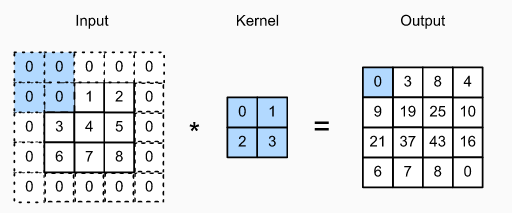
So if a 𝑛∗𝑛 matrix convolved with an f*f matrix the with padding p then the size of the output image will be (n + 2p — f + 1) * (n + 2p — f + 1) where p =1 in this case.

Stride
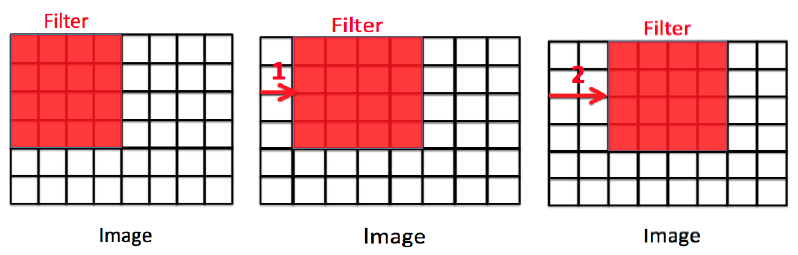
left image: stride =0, middle image: stride = 1, right image: stride =2

left image: stride =0, middle image: stride = 1, right image: stride =2
Stride is the number of pixels shifts over the input matrix. For padding p, filter size 𝑓∗𝑓 and input image size 𝑛 ∗ 𝑛 and stride ‘𝑠’ our output image dimension will be [ {(𝑛 + 2𝑝 − 𝑓 + 1) / 𝑠} + 1] ∗ [ {(𝑛 + 2𝑝 − 𝑓 + 1) / 𝑠} + 1].

Pooling
A pooling layer is another building block of a CNN. Pooling Its function is to progressively reduce the spatial size of the representation to reduce the network complexity and computational cost.

There are two types of widely used pooling in CNN layer:

Max Pooling
Average Pooling
Max Pooling

Max pooling is simply a rule to take the maximum of a region and it helps to proceed with the most important features from the image. Max pooling selects the brighter pixels from the image. It is useful when the background of the image is dark and we are interested in only the lighter pixels of the image.
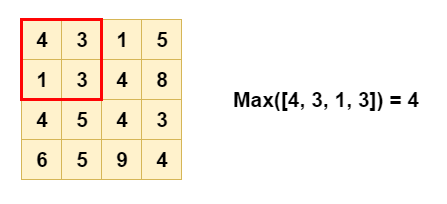
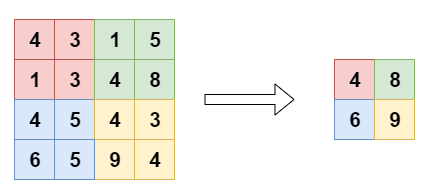



Average Pooling

Average Pooling is different from Max Pooling in the sense that it retains much information about the “less important” elements of a block, or pool. Whereas Max Pooling simply throws them away by picking the maximum value, Average Pooling blends them in. This can be useful in a variety of situations, where such information is useful.
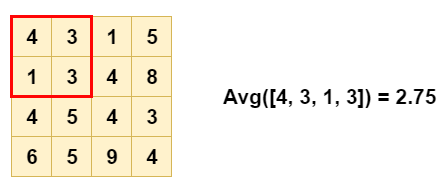
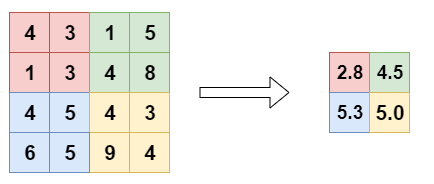

reference
https://medium.com/analytics-vidhya/convolution-padding-stride-and-pooling-in-cnn-13dc1f3ada26




3. Fit a CNN model on the dataset which has been assigned to you. Print a classification report to 
see the model metrics on train and test datasets.

In [9]:
import os
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio
!pip install --no-dependencies imgaug
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

# how many breeds and pictures we have

In [3]:
breed_list = os.listdir(r"C:\Users\Hp\Downloads\dogbreeds/images/Images")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(r"C:\Users\Hp\Downloads\dogbreeds/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


# label strings and numbers mapping

In [10]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

# show some pictures

In [4]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = r"C:\Users\Hp\Downloads\dogbreeds/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02105162-malinois


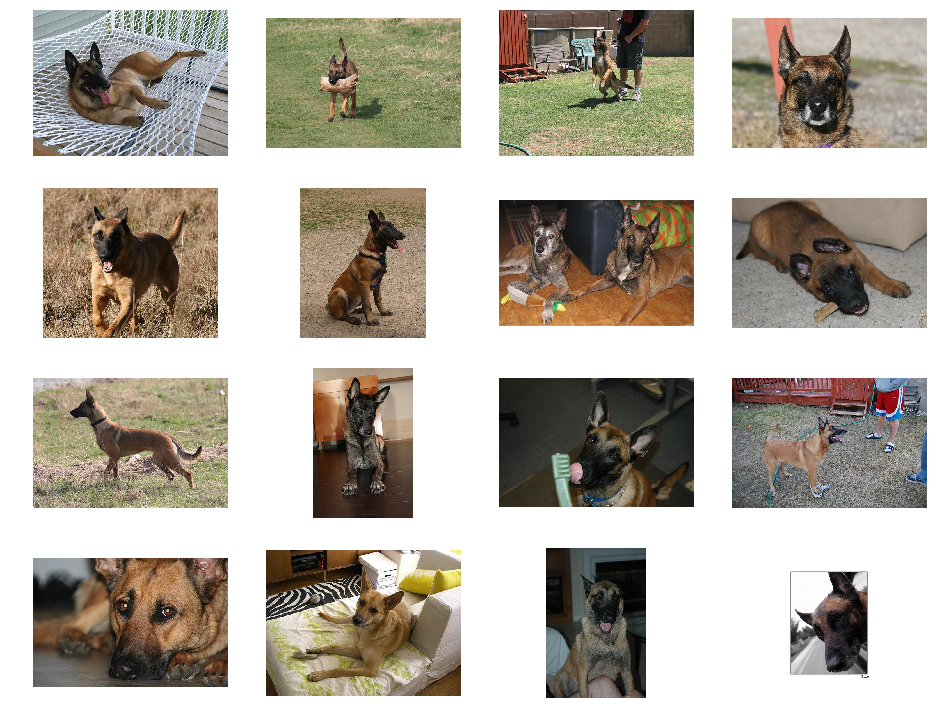

In [5]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

# crop and save pictures

In [5]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('dataf')
for breed in breed_list:
    os.mkdir('dataf/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('dataf'))))

for breed in os.listdir('dataf'):
    for file in os.listdir(r'C:\Users\Hp\Downloads\dogbreeds\annotations/Annotation/{}'.format(breed)):
        img = Image.open(r'C:\Users\Hp\Downloads\dogbreeds/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse(r'C:\Users\Hp\Downloads\dogbreeds/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('dataf/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
Wall time: 2min 49s


# prepare X and y

In [11]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./dataf/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

# image generator with augment

In [8]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

# train test split

In [9]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

# keras pretrain densenet121 model

In [12]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights=r"C:\Users\Hp\Downloads\densenet/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

# only train our last 6 layers

In [11]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [12]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [13]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
547/547 [==============================] - 82s 150ms/step - loss: 3.8430 - acc: 0.1168 - val_loss: 1.7271 - val_acc: 0.4953
Epoch 2/20
547/547 [==============================] - 74s 135ms/step - loss: 2.7185 - acc: 0.2781 - val_loss: 1.3762 - val_acc: 0.5721
Epoch 3/20
547/547 [==============================] - 78s 142ms/step - loss: 2.4097 - acc: 0.3448 - val_loss: 1.2332 - val_acc: 0.6012
Epoch 4/20
547/547 [==============================] - 74s 135ms/step - loss: 2.2865 - acc: 0.3773 - val_loss: 1.1944 - val_acc: 0.6242
Epoch 5/20
547/547 [==============================] - 75s 137ms/step - loss: 2.2258 - acc: 0.3901 - val_loss: 1.2450 - val_acc: 0.6132
Epoch 6/20
547/547 [==============================] - 72s 132ms/step - loss: 2.1417 - acc: 0.4065 - val_loss: 1.1516 - val_acc: 0.6356
Epoch 7/20
547/547 [==============================] - 73s 134ms/step - loss: 2.1120 - acc: 0.4138 - val_loss: 1.1372 - val_acc: 0.6359
Epoch 8

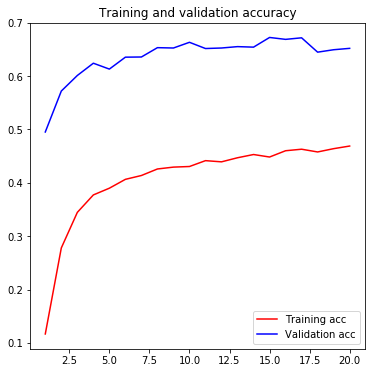

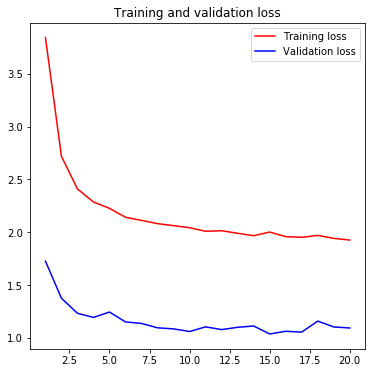

In [14]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# now train all layers

In [15]:
for layer in model.layers[:]:
    layer.trainable = True

In [16]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [17]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 73s 134ms/step - loss: 1.9093 - acc: 0.4759 - val_loss: 1.0673 - val_acc: 0.6621

Epoch 00001: val_acc improved from -inf to 0.66213, saving model to dog_breed_classifier_model.h5
Epoch 2/20
547/547 [==============================] - 72s 132ms/step - loss: 1.9035 - acc: 0.4718 - val_loss: 1.0794 - val_acc: 0.6579

Epoch 00002: val_acc did not improve from 0.66213

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/20
547/547 [==============================] - 72s 132ms/step - loss: 1.7525 - acc: 0.5065 - val_loss: 0.9695 - val_acc: 0.6936

Epoch 00003: val_acc improved from 0.66213 to 0.69355, saving model to dog_breed_classifier_model.h5
Epoch 4/20
547/547 [==============================] - 72s 132ms/step - loss: 1.6927 - acc: 0.5253 - val_loss: 0.9784 - val_acc: 0.7036

Epoch 00004: val_acc improved from 0.69355 to 0.70360, saving model to dog_breed_classifier_model.h5

Epoch 00004: ReduceLROn

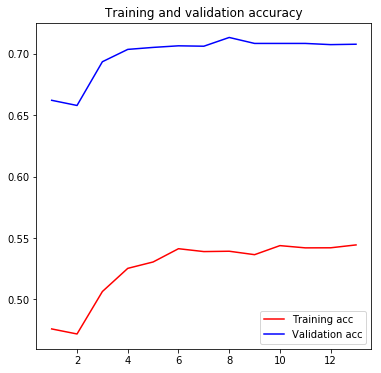

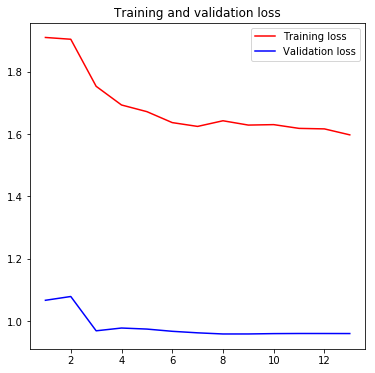

In [18]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [19]:
print(max(val_acc))

0.7133138970645995


# predict new images

download some dog images from pixabay for testing

In [20]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

63.66% 	 malinois
11.83% 	 dingo
9.54% 	 German_shepherd
8.42% 	 dhole
5.04% 	 kelpie


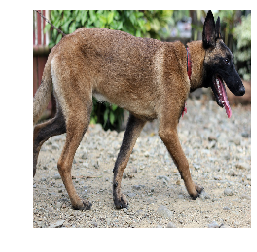

In [21]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

85.36% 	 Pembroke
14.56% 	 Cardigan
0.06% 	 dingo
0.01% 	 kelpie
0.00% 	 German_shepherd


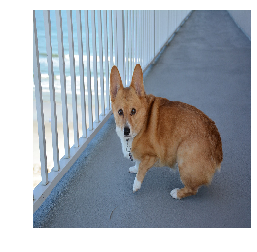

In [22]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

46.01% 	 miniature_pinscher
35.69% 	 Chihuahua
16.56% 	 toy_terrier
0.74% 	 Boston_bull
0.27% 	 Italian_greyhound


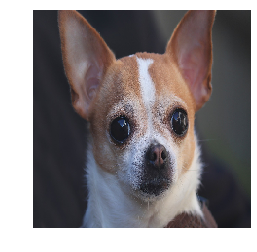

In [23]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

78.07% 	 redbone
9.65% 	 Rhodesian_ridgeback
3.49% 	 vizsla
2.31% 	 bloodhound
1.48% 	 beagle


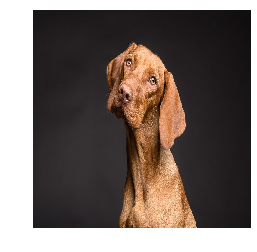

In [24]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

58.41% 	 golden_retriever
34.23% 	 Labrador_retriever
2.52% 	 Rhodesian_ridgeback
2.49% 	 Chesapeake_Bay_retriever
0.80% 	 redbone


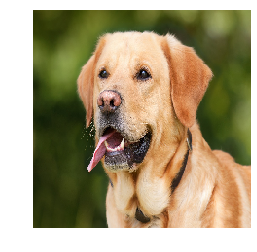

In [25]:
download_and_predict("https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_1280.jpg",
                     "test_5.jpg")

4. What is overfitting? How to overcome overfitting in an ML model?

In [ ]:
4.

A statistical model is said to be overfitted when we feed it a lot more data than 
necessary. When a model fits more data than it actually needs, it starts 
catching the noisy data and inaccurate values in the data. As a result, the 
efficiency and accuracy of the model decrease. 
There are several techniques to avoid overfitting in Machine Learning altogether 
listed below. 
1. Cross-Validation 
2. Training With More Data 
3. Removing Features 
4. Early Stopping 
5. Regularization 
6. Ensembling 

 Cross-Validation
 
 
One of the most powerful features to avoid/prevent overfitting is crossvalidation. The idea behind this is to use the initial training data to generate mini 
train-test-splits, and then use these splits to tune your model. 
In a standard k-fold validation, the data is partitioned into k-subsets also known 
as folds. After this, the algorithm is trained iteratively on k-1 folds while using 
the remaining folds as the test set, also known as holdout fold. 
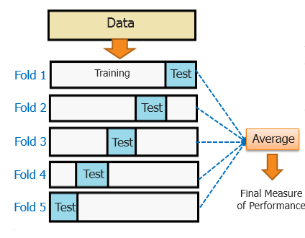
The cross-validation helps us to tune 
the hyperparameters with only the original training set. It basically keeps the 
test set separately as a true unseen data set for selecting the final model. Hence, 
avoiding overfitting altogether
.
 Training With More Data
 
This technique might not work every time, as we have also discussed in the 
example above, where training with a significant amount of population helps 
the model. It basically helps the model in identifying the signal better. 
But in some cases, the increased data can also mean feeding more noise to the 
model. When we are training the model with more data, we have to make sure 
the data is clean and free from randomness and inconsistencies. 


 Removing Features
 
 
Although some algorithms have an automatic selection of features. For a 
significant number of those who do not have a built-in feature selection, we can 
manually remove a few irrelevant features from the input features to improve 
the generalization. 
One way to do it is by deriving a conclusion as to how a feature fits into the 
model. It is quite similar to debugging the code line-by-line. 
In case if a feature is unable to explain the relevancy in the model, we can simply 
identify those features. We can even use a few feature selection heuristics for a 
good starting point. 

 Early Stopping
 
When the model is training, you can actually measure how well the model 
performs based on each iteration. We can do this until a point when the 
iterations improve the model’s performance. After this, the model overfits the 
training data as the generalization weakens after each iteration. 
So basically, early stopping means stopping the training process before the 
model passes the point where the model begins to overfit the training data. This 
technique is mostly used in deep learning.


 Regularization
 
It basically means, artificially forcing your model to be simpler by using a broader 
range of techniques. It totally depends on the type of learner that we are using. 
For example, we can prune a decision tree, use a dropout on a neural network or 
add a penalty parameter to the cost function in regression. 
Quite often, regularization is a hyperparameter as well. It means it can also be 
tuned through cross-validation. 


 Ensembling
 
This technique basically combines predictions from different Machine Learning 
models. Two of the most common methods for ensembling are listed below: 
 Bagging attempts to reduce the chance overfitting the models 
 Boosting attempts to improve the predictive flexibility of simpler models 
Even though they are both ensemble methods, the approach totally starts from 
opposite directions. Bagging uses complex base models and tries to smooth out 
their predictions while boosting uses simple base models and tries to boost its 
aggregate complexity. 
In statistic modeling, the goodness of fit refers to how closely the outcomes or 
predicted values match the observed or true values. A model that has learned 
noise instead of the signal is overfitted because it will fit the training data set 
but will have poorer efficiency with the new data set. 

References 
https://www.edureka.co/blog/overfitting-in-machine-learning/